<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/1_finalW207_Breast_Cancer_IDC_Prediction_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
**Heesuk Jang**
 

#Predicting IDC (Invasive Ductal Carcinoma 침윤성 유관암) with Breast Histopathology (조직병리학) Images using a CNN

In [2]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%pwd

'/content'

## Load data as a zip file directly from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images) to Colab

In [3]:
# !kaggle datasets download -d paultimothymooney/breast-histopathology-images

## Unzip the downloaded zip and remove the original zip file

In [4]:
# !unzip \*.zip && rm *.zip

In [3]:
%ls

10253/  10305/  12881/  13018/  14153/  16085/  8980/  9255/
10254/  10306/  12882/  13019/  14154/  16165/  8984/  9256/
10255/  10307/  12883/  13020/  14155/  16166/  9022/  9257/
10256/  10308/  12884/  13021/  14156/  16167/  9023/  9258/
10257/  12241/  12886/  13022/  14157/  16531/  9029/  9259/
10258/  12242/  12890/  13023/  14188/  16532/  9035/  9260/
10259/  12626/  12891/  13024/  14189/  16533/  9036/  9261/
10260/  12748/  12892/  13025/  14190/  16534/  9037/  9262/
10261/  12749/  12893/  13106/  14191/  16550/  9041/  9265/
10262/  12750/  12894/  13400/  14192/  16551/  9043/  9266/
10264/  12751/  12895/  13401/  14209/  16552/  9044/  9267/
10268/  12752/  12896/  13402/  14210/  16553/  9073/  9290/
10269/  12810/  12897/  13403/  14211/  16554/  9075/  9291/
10272/  12811/  12898/  13404/  14212/  16555/  9076/  9319/
10273/  12817/  12900/  13458/  14213/  16568/  9077/  9320/
10274/  12818/  12901/  13459/  14304/  16569/  9078/  9321/
10275/  12819/  12905/  

In [6]:
# main_fol = '/Users/heesukjang/Desktop/W207_Fall2022_AppliedML/Final_Project_BreastCancerClassification/data/archive/IDC_regular_ps50_idx5/'
# idc_folder = os.path.join(main_fol + '*/1/')
# non_idc_folder = os.path.join(main_fol + '*/0/')

# idc_images = glob.glob(idc_folder + '*.png')
# idc_list = [x for x in idc_images]
# print(idc_list)

## Read image files from **IDC_regular_ps50_idx5**

In [4]:
def read_image_files(binary_class):
  current_working_dir = os.getcwd()
  folder = 'IDC_regular_ps50_idx5/*/'

  image_files_w_path, image_files_wo_path = [], []
  for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
    image_files_w_path.append(img)
    image_wo_path = os.path.basename(img)
    image_files_wo_path.append(image_wo_path)    
  return image_files_wo_path, image_files_w_path

class_1_malignant_wo_path, class_1_malignant_w_path = read_image_files('1')
class_0_benign_wo_path, class_0_benign_w_path = read_image_files('0')
full_data_wo_path = class_1_malignant_wo_path + class_0_benign_wo_path
full_data_w_path = class_1_malignant_w_path + class_0_benign_w_path

print('class_1:\n',class_1_malignant_wo_path[:2])
print('\nclass_0:\n',class_0_benign_wo_path[:2])
print('\nclass_1 and class_0 combined:\n',full_data_wo_path[0], ',', full_data_wo_path[-1])
print('\nclass_1 with full path:\n',class_1_malignant_w_path[:2])

class_1:
 ['12884_idx5_x1701_y601_class1.png', '12884_idx5_x1501_y951_class1.png']

class_0:
 ['12884_idx5_x1001_y1101_class0.png', '12884_idx5_x951_y1101_class0.png']

class_1 and class_0 combined:
 12884_idx5_x1701_y601_class1.png , 9347_idx5_x901_y151_class0.png

class_1 with full path:
 ['/content/IDC_regular_ps50_idx5/12884/1/12884_idx5_x1701_y601_class1.png', '/content/IDC_regular_ps50_idx5/12884/1/12884_idx5_x1501_y951_class1.png']


## Check the number of image files in each class


In [5]:
def check_class_size(class_1, class_0):
  class_1_size, class_0_size = len(class_1), len(class_0)
  count = pd.Series([class_1_size, class_0_size])
  percent = round(count/(class_1_size + class_0_size)*100, 2)
  df_perc = pd.concat({'class_count':count, 'class_percent(%)':percent}, axis=1)
  df_perc['class'] = ['Class 1 (Malignant)', 'Class 0 (Benign)']
  df_perc = df_perc[['class','class_count','class_percent(%)']]
  print('Total Count = ', class_1_size + class_0_size)
  return df_perc

check_class_size(class_1_malignant_wo_path, class_0_benign_wo_path)

Total Count =  277524


,class,class_count,class_percent(%)
0,Class 1 (Malignant),78786,28.39
1,Class 0 (Benign),198738,71.61


## Create dataframes for each class

In [6]:
def create_class_df(): 
  image_list_w_path = [x for x in class_1_malignant_w_path]
  image_list_w_path.extend([x for x in class_0_benign_w_path])
  df_idc= pd.DataFrame(np.concatenate([['IDC']*len(class_1_malignant_w_path), ['Non_IDC']*len(class_0_benign_w_path)]), columns=['class_str'])
  df_idc['class'] = np.where(df_idc.class_str == 'IDC', 1, 0)
  df_idc['image'] = [x for x in image_list_w_path]
  print('Shape: ', df_idc.shape)
  return df_idc

df_full = create_class_df()
df_full

Shape:  (277524, 3)


,class_str,class,image
0,IDC,1,/content/IDC_regular_ps50_idx5/12884/1/12884_i...
1,IDC,1,/content/IDC_regular_ps50_idx5/12884/1/12884_i...
2,IDC,1,/content/IDC_regular_ps50_idx5/12884/1/12884_i...
3,IDC,1,/content/IDC_regular_ps50_idx5/12884/1/12884_i...
4,IDC,1,/content/IDC_regular_ps50_idx5/12884/1/12884_i...
...,...,...,...
277519,Non_IDC,0,/content/IDC_regular_ps50_idx5/9347/0/9347_idx...
277520,Non_IDC,0,/content/IDC_regular_ps50_idx5/9347/0/9347_idx...
277521,Non_IDC,0,/content/IDC_regular_ps50_idx5/9347/0/9347_idx...
277522,Non_IDC,0,/content/IDC_regular_ps50_idx5/9347/0/9347_idx...


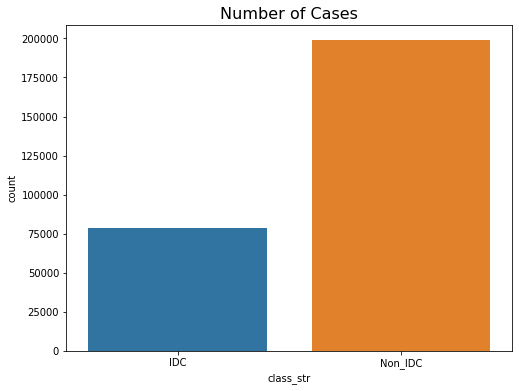

In [7]:
plt.figure(figsize=(8,6))
plt.title('Number of Cases', fontsize=16)
sns.countplot(df_full['class_str'], data=df_full)
plt.show()

# 1. Binary Classification 
: IDC vs Non-IDC



## Display 6 images for each class
: 512 (width) by 512 (height) array of pixel values per image

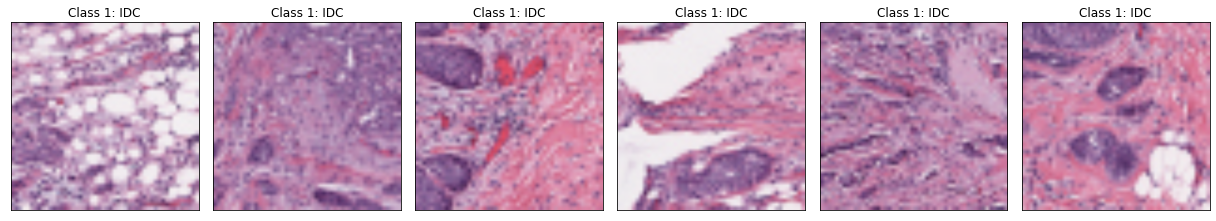

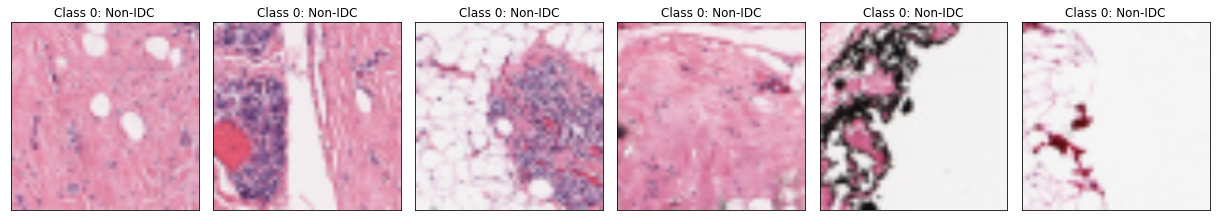

In [8]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  # images = []
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (512,512))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    ax.set_xticks([])       # remove xticks passing an empty array
    ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(class_1_malignant_w_path, 'Class 1: IDC')
display_images(class_0_benign_w_path, 'Class 0: Non-IDC')

## Store actual images as a vector

In [9]:
# read and store actual images (not the image paths) into the respective variable as a single vector then pass these to the model below
image_pixels_class1 = [io.imread(img) for img in class_1_malignant_w_path]
image_pixels_class0 = [io.imread(img) for img in class_0_benign_w_path]

print('number of class 1 images = ', len(image_pixels_class1))
print('number of class 0 images = ', len(image_pixels_class0))
print('total number of images = ', len(image_pixels_class1 + image_pixels_class0))

number of class 1 images =  78786
number of class 0 images =  198738
total number of images =  277524


## Specify image data (X) and labels (y)

In [10]:
X = np.array(image_pixels_class1 + image_pixels_class0)
y = np.array(df_full['class'])
print('y: total number of images = ', len(y), type(y) ,'\n', y[:5], y[-5:])
print('\nX: total number of images = ', len(X), type(X), '\n', X[0])

y: total number of images =  277524 <class 'numpy.ndarray'> 
 [1 1 1 1 1] [0 0 0 0 0]

X: total number of images =  277524 <class 'numpy.ndarray'> 
 [[[186 135 177]
  [162 120 161]
  [214 192 208]
  ...
  [243 239 241]
  [242 238 240]
  [235 222 230]]

 [[206 171 199]
  [198 168 191]
  [188 143 182]
  ...
  [235 231 238]
  [164 148 179]
  [210 179 206]]

 [[203 176 201]
  [218 192 211]
  [195 163 191]
  ...
  [155 131 174]
  [154 118 157]
  [163 144 167]]

 ...

 [[193 168 194]
  [122  80 133]
  [170 145 180]
  ...
  [173  90 132]
  [170 118 157]
  [237 222 232]]

 [[146 126 168]
  [184 156 187]
  [214 190 209]
  ...
  [158 104 146]
  [192 145 181]
  [203 164 192]]

 [[174 135 172]
  [125  98 147]
  [172 156 186]
  ...
  [183 144 180]
  [197 163 191]
  [202 159 192]]]


## Randomize images (X) and labels (y) 


In [11]:
#  randomize image data
# (X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = full_image_pixels
import numpy as np
np.random.seed(0)
shuffled_y = shuffle(y)
print(len(y), '\n', shuffled_y[:10])
shuffled_X = shuffle(X)
print('\n',len(X), '\n', shuffled_X[0])

277524 
 [0 1 1 1 1 1 0 0 0 0]

 277524 
 [[[221 121 156]
  [215 125 159]
  [227 152 180]
  ...
  [221 155 181]
  [222 158 184]
  [230 196 211]]

 [[236 216 219]
  [240 193 211]
  [235 179 198]
  ...
  [233 194 211]
  [216 164 186]
  [224 142 179]]

 [[197 165 195]
  [236 210 224]
  [224 175 200]
  ...
  [227 161 189]
  [230 166 188]
  [224 156 180]]

 ...

 [[234 179 203]
  [215 142 172]
  [217 147 178]
  ...
  [197 114 159]
  [223 124 158]
  [223 117 153]]

 [[213 148 181]
  [199 158 188]
  [128  81 126]
  ...
  [215 133 172]
  [224 142 175]
  [226 131 165]]

 [[160 117 159]
  [186 123 167]
  [192 123 161]
  ...
  [216 135 171]
  [222 136 172]
  [221 162 189]]]


## Train/Test Split (80/20)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(shuffled_X, shuffled_y, test_size=0.2, random_state=42)

# X_train = X_train / 255
# X_test = X_test / 255
print('X_train.shape: ',X_train.shape, ' | Each input image shape: ', X_train[0].shape)
print('X_test.shape: ',X_test.shape, ' | Each input image shape: ', X_test[0].shape)
print('\ny_train.shape: ',y_train.shape, '=> 10 sample data: ', y_train[-10:] )
print('y_test.shape: ',y_test.shape, '=> 10 sample data: ', y_test[-10:] )
print('\nOne image 3D pixels in X_test):\n', X_test[0])

X_train.shape:  (222019,)  | Each input image shape:  (50, 50, 3)
X_test.shape:  (55505,)  | Each input image shape:  (50, 50, 3)

y_train.shape:  (222019,) => 10 sample data:  [0 0 0 0 0 1 0 0 0 0]
y_test.shape:  (55505,) => 10 sample data:  [0 0 0 1 0 1 1 0 0 0]

One image 3D pixels in X_test):
 [[[217 150 179]
  [213 148 173]
  [198 120 154]
  ...
  [167 105 143]
  [162 124 163]
  [145 114 144]]

 [[210 140 164]
  [227 178 203]
  [218 162 185]
  ...
  [181 126 161]
  [180 116 153]
  [207 154 188]]

 [[203 136 173]
  [137 103 137]
  [181 152 178]
  ...
  [198 147 179]
  [211 161 185]
  [187 132 164]]

 ...

 [[190 117 155]
  [218 155 183]
  [220 133 163]
  ...
  [210 140 171]
  [209 147 177]
  [203 144 173]]

 [[180 104 142]
  [211 120 154]
  [212 139 169]
  ...
  [197 130 166]
  [197 135 172]
  [182 118 157]]

 [[221 160 184]
  [218 137 169]
  [223 159 187]
  ...
  [214 140 172]
  [210 132 164]
  [200 124 161]]]


In [16]:
X_test_norm = X_test[:20000] / 255
print(X_test_norm[0])

[[[0.85098039 0.58823529 0.70196078]
  [0.83529412 0.58039216 0.67843137]
  [0.77647059 0.47058824 0.60392157]
  ...
  [0.65490196 0.41176471 0.56078431]
  [0.63529412 0.48627451 0.63921569]
  [0.56862745 0.44705882 0.56470588]]

 [[0.82352941 0.54901961 0.64313725]
  [0.89019608 0.69803922 0.79607843]
  [0.85490196 0.63529412 0.7254902 ]
  ...
  [0.70980392 0.49411765 0.63137255]
  [0.70588235 0.45490196 0.6       ]
  [0.81176471 0.60392157 0.7372549 ]]

 [[0.79607843 0.53333333 0.67843137]
  [0.5372549  0.40392157 0.5372549 ]
  [0.70980392 0.59607843 0.69803922]
  ...
  [0.77647059 0.57647059 0.70196078]
  [0.82745098 0.63137255 0.7254902 ]
  [0.73333333 0.51764706 0.64313725]]

 ...

 [[0.74509804 0.45882353 0.60784314]
  [0.85490196 0.60784314 0.71764706]
  [0.8627451  0.52156863 0.63921569]
  ...
  [0.82352941 0.54901961 0.67058824]
  [0.81960784 0.57647059 0.69411765]
  [0.79607843 0.56470588 0.67843137]]

 [[0.70588235 0.40784314 0.55686275]
  [0.82745098 0.47058824 0.60392157]


In [41]:
xtrain_idx = list(range(0, X_train.shape[0], 50000))
xtrain_idx.extend([X_train.shape[0]])
print(type(xtrain_idx), xtrain_idx)

step_size = 10000
xtest_idx = list(range(0, X_test.shape[0]-step_size, step_size))
last_idx = X_test.shape[0] - xtest_idx[-1]
# xtest_idx.extend([X_test.shape[0]])
print(type(xtest_idx), xtest_idx)
print('last_idx: ',last_idx)

<class 'list'> [0, 50000, 100000, 150000, 200000, 222019]
<class 'list'> [0, 10000, 20000, 30000, 40000]
last_idx:  15505


In [40]:
# X_test_10 = X_test[:10]
# print()
step_size = 10000
initial_array = np.array([])
for idx, step_idx in enumerate(xtest_idx):
# for i in range(5):
  print('initial_array: ',type(initial_array), initial_array.shape)
  print('i:', idx, 'step_idx: ', step_idx, 'step_idx+10000: ', step_idx+step_size)
  # print(X_test_10[i])
  # normalized_img = X_test[0:10000] / 255
  # normalized_img = X_test[10000:20000] / 255
  # normalized_img = X_test[20000:30000] / 255
  # normalized_img = X_test[30000:40000] / 255
  # normalized_img = X_test[40000:50000] / 255
# #   # print('xtest_idx[i]: ', xtest_idx[i])
# # #   normalized_img = X_test[xtest_idx[i]:xtest_idx[1+1]] / 255
#   full_normalized = np.concatenate((initial_array, normalized_img), axis=0)
#   initial_array = normalized_img
#   print('full_normalized shape: ', full_normalized.shape)
# print(full_normalized.shape, full_normalized)

initial_array:  <class 'numpy.ndarray'> (0,)
i: 0 step_idx:  0 step_idx+10000:  10000
initial_array:  <class 'numpy.ndarray'> (0,)
i: 1 step_idx:  10000 step_idx+10000:  20000
initial_array:  <class 'numpy.ndarray'> (0,)
i: 2 step_idx:  20000 step_idx+10000:  30000
initial_array:  <class 'numpy.ndarray'> (0,)
i: 3 step_idx:  30000 step_idx+10000:  40000
initial_array:  <class 'numpy.ndarray'> (0,)
i: 4 step_idx:  40000 step_idx+10000:  50000


In [19]:
# X_train_norm = X_train[:60000] / 255
X_train_norm_1 = X_train[:90000] / 255
print(X_train_norm_1[0])

[[[0.45490196 0.27058824 0.51372549]
  [0.44313725 0.27843137 0.5254902 ]
  [0.70196078 0.5372549  0.70196078]
  ...
  [0.8        0.65098039 0.79607843]
  [0.77254902 0.55294118 0.72941176]
  [0.6627451  0.40784314 0.61960784]]

 [[0.6627451  0.48235294 0.67058824]
  [0.67058824 0.4627451  0.66666667]
  [0.74901961 0.63137255 0.77647059]
  ...
  [0.58431373 0.42745098 0.62352941]
  [0.74901961 0.56470588 0.71764706]
  [0.90588235 0.87058824 0.89411765]]

 [[0.55686275 0.43921569 0.61960784]
  [0.55294118 0.33333333 0.56470588]
  [0.5372549  0.37647059 0.57647059]
  ...
  [0.5372549  0.37254902 0.53333333]
  [0.93333333 0.92156863 0.92941176]
  [0.94509804 0.94117647 0.94117647]]

 ...

 [[0.89019608 0.81176471 0.87058824]
  [0.94117647 0.92941176 0.94117647]
  [0.94901961 0.93333333 0.94117647]
  ...
  [0.83137255 0.71372549 0.81960784]
  [0.50588235 0.31372549 0.50980392]
  [0.63921569 0.49803922 0.63921569]]

 [[0.76470588 0.53333333 0.71764706]
  [0.9254902  0.89019608 0.91764706]


In [20]:
X_train_norm_2 = X_train[100000:105000] / 255
print(X_train_norm_2[0])

[[[0.96862745 0.95686275 0.96862745]
  [0.96078431 0.95294118 0.96470588]
  [0.96470588 0.95686275 0.96470588]
  ...
  [0.82745098 0.48627451 0.66666667]
  [0.8        0.41960784 0.63529412]
  [0.66666667 0.35294118 0.6       ]]

 [[0.96470588 0.95294118 0.96470588]
  [0.96078431 0.96078431 0.96078431]
  [0.96078431 0.95686275 0.96470588]
  ...
  [0.87058824 0.5254902  0.72156863]
  [0.82745098 0.43529412 0.65882353]
  [0.82352941 0.40784314 0.61568627]]

 [[0.96078431 0.95686275 0.96078431]
  [0.96470588 0.96862745 0.96470588]
  [0.96470588 0.95294118 0.96862745]
  ...
  [0.84313725 0.47843137 0.68235294]
  [0.88235294 0.51372549 0.70588235]
  [0.82745098 0.42352941 0.63921569]]

 ...

 [[0.59607843 0.16470588 0.34117647]
  [0.67843137 0.18039216 0.34509804]
  [0.65098039 0.1372549  0.29411765]
  ...
  [0.85098039 0.50196078 0.70980392]
  [0.83921569 0.50196078 0.68627451]
  [0.8745098  0.51372549 0.69803922]]

 [[0.7254902  0.21568627 0.41568627]
  [0.72156863 0.2627451  0.45882353]


In [21]:
# X_train_norm_1 = X_train[:100000] / 255
X_train_norm_2 = X_train[100000:110000] / 255
X_train_norm_3 = X_train[105000:110000] / 255
X_train_norm_4 = X_train[110000:115000] / 255
X_train_norm_5 = X_train[115000:120000] / 255
X_train_norm_6 = X_train[120000:125000] / 255
X_train_norm_7 = X_train[125000:130000] / 255
print(X_train_norm_2[0])

[[[0.96862745 0.95686275 0.96862745]
  [0.96078431 0.95294118 0.96470588]
  [0.96470588 0.95686275 0.96470588]
  ...
  [0.82745098 0.48627451 0.66666667]
  [0.8        0.41960784 0.63529412]
  [0.66666667 0.35294118 0.6       ]]

 [[0.96470588 0.95294118 0.96470588]
  [0.96078431 0.96078431 0.96078431]
  [0.96078431 0.95686275 0.96470588]
  ...
  [0.87058824 0.5254902  0.72156863]
  [0.82745098 0.43529412 0.65882353]
  [0.82352941 0.40784314 0.61568627]]

 [[0.96078431 0.95686275 0.96078431]
  [0.96470588 0.96862745 0.96470588]
  [0.96470588 0.95294118 0.96862745]
  ...
  [0.84313725 0.47843137 0.68235294]
  [0.88235294 0.51372549 0.70588235]
  [0.82745098 0.42352941 0.63921569]]

 ...

 [[0.59607843 0.16470588 0.34117647]
  [0.67843137 0.18039216 0.34509804]
  [0.65098039 0.1372549  0.29411765]
  ...
  [0.85098039 0.50196078 0.70980392]
  [0.83921569 0.50196078 0.68627451]
  [0.8745098  0.51372549 0.69803922]]

 [[0.7254902  0.21568627 0.41568627]
  [0.72156863 0.2627451  0.45882353]


In [ ]:
X_train_norm_8 = X_train[130000:140000] / 255
print(type(X_train_norm_8), X_train_norm_8[0])
con = np.concatenate((X_train_norm_7, X_train_norm_8), axis=0)
print(con[0])

In [ ]:
X_train_norm_4 = X_train[110000:115000] / 255
print(X_train_norm_4[0])

## Set 20% of validation data out of training dataset
We don't want to just optimize our model and its hyperparameters for just these train and test data sets. There is a chance that the model will perform badly on unseen data because it hasn't really had the chance to test itself against one. 

To mitigate this, we'll take 20% of our training data and put it into validation data. We'll be optimizing our model on these two before introducing it to our test dataset.

In [ ]:
'''
set random_state for repeatability and stratify to make the function understand 
that the portion we split from original df must contain the same proportion of elements as in the original df. 
i.e. suppose for every 10 observations you have 7 IDC and 3 non-IDC in the training dataset. we want the same proportion in the validataion as well.
'''
# train_df, val_df = train_test_split(train, test_size=0.2, random_state=13, stratify=train['class'])

## Preprocessing (Normalization)
Normalization helps our algorithm train better. The reason why we typically want normalized pixel values is becasue **neural networks rely on gradient calculations.** These networks are trying to learn how important or how weighty a certain pixel should be in determining the class of an image. Normalizing pixel values help these gradient calculations stay consistent and not get so large that they slow don or prevent network from training. In a typical grayscale image, the pixel values will range from 0-255. we will be using **ImageDataGenerator** to preprocess our data.

In [ ]:
from keras_preprocessing.image import image_data_generator
# ImageDataGenerator allows the users to perform image augmentation but here we will repurpose it to just normalize our images
# Rescale all the pixel valuesin our images to a value in the range of 0 to 1.
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale=1/255)
# val_norm = ImageDataGenerator(rescale=1/255)

# train_norm_vector = np.reshape(train_norm, (67500,))

In [ ]:
generator = image_generator.flow_from_dataframe(
      X_train,
      x_col='image',
      y_col='class',
      targt_size=(150,150),   # larger images increasing training time with no substantial benefit so resize to smaller scale
      batch_size=32,
      class_mode='binary',    # two classes (IDC vs Non-IDC)
      shuffle=binary,
      seed=7
  )

## Feed nomalized train, validataion, and test images to CNN
We need a way to read and then feed to our CNN all those rescaled images from our dataframes and that is where the method flow_from_dataframe comes in.
- **targt_size=(150,150):** can increase or decrease this according to your computational resources.
- **batch_size:** defines the number of samples that we've propagated through the network, basically, number of images per batch that is fed into the CNN. This value typically ranges from 16 - 512. Large batch sizes require more computational power so we here have set this to 32.


In [ ]:
def generate_input_images_to_feed_cnn(df_norm, df, binary):
  '''flow_from_dataframe() generates batches of input iamges that can be used as the input to our network'''  
  generator = df_norm.flow_from_dataframe(
      df,
      x_col='image',
      y_col='class',
      targt_size=(150,150),   # larger images increasing training time with no substantial benefit so resize to smaller scale
      batch_size=32,
      class_mode='binary',    # two classes (IDC vs Non-IDC)
      shuffle=binary,
      seed=7
  )
  return generator

train_generator = generate_input_images_to_feed_cnn(train_norm, train_df, 'True')
val_generator = generate_input_images_to_feed_cnn(val_norm, val_df, 'True')

# shuffle to False on the test_generator since we don't want ImageDataGenerator to be shuffling the test,which it does so by default
test_generator = generate_input_images_to_feed_cnn(val_norm, test, 'False') 

train_generator

## Feature Extraction
The layout of a CNN can be broadly divided into feature extraction and classification.
- **Convolutions:**<br>
    1) Input image<br>
    2) Filter<br>
    3) Feature maps<br>
- **Activation:**<br>
    1) Sigmoid<br>
    2) Tanh<br>
    3) ReLU<br>
    2) Leaky ReLU<br>
- **Pooling:**<br>
    1) Max pooling<br>

## Classification
For classification, the output of the previous layer, that is, the last layer in **feature extraction** becomes the input to what is called the **fully connected layer**. The fully connected layer outputs an undimensional vector where N is the **number of classes**. For example, in a cat or dog problem, N=2. And in a digit classification where the network is supposed to say which digit it is from 0 to 9, N=10. Each number of the N-dimensional vector contains the probability of that particular class, and the class with the highest probability is chosen.

## Model Architecture
Every one of the following parameters can be changed and experimented with to see how it affects the network and its performance, and these things are called **hyperparameters**.
- **filters:** the number of filters we want. let's start with 16
- **kernel_size:** = filter size. A filter is also called **kernel**. Set it to (3,3) = (width, height)
- **activation:** will go with **ReLu**
- **input_shape:** the input dimensions of the image. This will be the same as what we told the ImageDataGenerator. We also have a **depth of 3** since these are color images. The input_shape param is only needed in the 1st convolutional layer.

**Conv2D = 2D convolution layer**. This layer creates a convolution kernel (= filter) that is convolved with the layer input to produce a tensor of outputs. The **number of layers** in a CNN also affects the network performance and is something that'll need to be played around with. For preparing data to be fed into a **fully connected layer**, we need to **flatten** the dataset. And then we'll pass the info to a fully connected layer. We'll be using two fully connected layers here. **Dense** indicates that it is indeed a fully connected layer.

For the **1st Dense layer**, we specify the **number of units or neurons**. Since this is a binary classification problem, we will have 1 neuron or 1 unit for the **final Dense layer**. If it was a **multi-class classification** problem, you will have as many units as there are classes. For the activation function, we will use **Sigmoid**, which we input the value of the last layer and we get a value in the range of 0 to 1. If the value is greater than the threshold value let's say 0.5, we consider the model output as one class or the other class of the value is less than the threshold value.  

Now we created the first CNN network! Now we need to **compile** it. This is where we specify the **configurations of the training process**. First we need to specify a **loss function**. The objective of the model will be **to minimize the loss function**. Since this is a binary classification problem, we will use **binary_crossentropy**. Then we'll specify what type of optimizer the model uses to do this. Optimizers are algorithms or methods, used to change the attributes of a neural network such as **weights and learning rate** in order **to reduce the losses**. They are many types of optimizers. We'll use the **adam optimizer**, which is arguably the most popular. Finally we'll also provide a **metric** for us to see how well the model is doing. Since this is a classification problem, **accuracy** whould work well. To get an overview of the model and the number of params that are in play, you can use **model.summary**.

## Build the first CNN model - Feature Extraction

In [ ]:
# Importing the necessary packages
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
def build_model():
  # Building the CNN
  model = Sequential()      # initialize the model using Sequential(), which indicates our network will be stacked with different layers

  # Add the convolutional layers
  model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))  # 1st convolutional layer
  model.add(MaxPooling2D(pool_size=(2,2)))                                                   # 1st Pooling
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))                           # 2nd convolutional layer
  model.add(MaxPooling2D(pool_size=(2,2)))                                                   # 2nd Pooling
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))                           # 3rd convolutional layer
  model.add(MaxPooling2D(pool_size=(2,2)))                                                   # 3rd Pooling

  # Flatten the dataset to feed into a fully connected layer
  model.add(Flatten())    # may not need it since I flatten the data prior

  # Fully connected layer
  model.add(Dense(64, activation='relu'))    # For the first layer: 64 = the number of units or neurons
  model.add(Dense(1, activation='sigmoid'))  # For the final layer

  # optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)   # Use the SGD optimizer 

  #  Compiling
  model.compile(loss='binary_crossentropy',
                optimizer='adam',                    # use SGD instead?: optimizer=optimizer
                metrics=['accuracy'])            # metrics=[metrics.binary_accuracy])
  return model

In [ ]:
model = build_model()
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

## Training the Model

In [ ]:
# There are many other args other th
# an the followin three that you can include here but right now, we're trying to build a minimum viable network.
# from tensorflow import keras
model_1 = model.fit(train_generator, epochs=10, validation_data=val_generator)     # Hyperparam which we can play around: one epoch includes the forward propagation and back propagation

model_1 = pd.DataFrame(model_1.history)
display(model_1)

In [ ]:
plt.figure(figsize=(12,8))

# Plot the loss function for training and validation datasets
plt.subplot(2,2,1)
plt.plot(model_1.history['loss'], label='Training Loss')
plt.plot(model_1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss - Training vs Validation Dataset')

# Plot the loss function for training and validation datasets
plt.subplot(2,2,2)
plt.plot(model_1.history['accuracy'], label='Training accuracy')
plt.plot(model_1.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy - Training vs Validation Dataset')

# 2. Prediction 
: predict the most common area that may be detected IDC


## Extract features from file names

In [ ]:
def extract_features(file_list): 
  features = []
  for file in file_list:
    str_feat = re.findall(r'\d+', file)
    int_feat = [int(feat) for feat in str_feat]
    features.append(int_feat)
  df_feat = pd.DataFrame(features, columns=['patient_id', 'd', 'x_coord', 'y_coord', 'class']).drop('d', axis=1)
  df_feat['patch_coord'] = list(zip(df_feat.x_coord, df_feat.y_coord))
  return df_feat[['patient_id','x_coord', 'y_coord', 'patch_coord','class']]

df_features = extract_features(full_data_wo_path)
print(df_features.shape)
display(df_features.head().append(df_features.tail()))

In [ ]:
df_features.info()

## Randomize data 
: As we may use SGD for training, we will randomize sample of the data for each batch so that the gradient computed is representative.

In [ ]:
indexes = np.arange(df_features.shape[0])
print('indexes:', indexes)

np.random.seed(0)    # get the same results each time    ??????
shuffled_indexes = np.random.permutation(indexes)
print('shuffled indexes:', shuffled_indexes, '\n')

# change the ordering of the original df_features using .reindex()
df_features = df_features.reindex(shuffled_indexes)
display(df_features)

## Train/Test split (80/20) & Feature Selection

In [ ]:
split_boundary = int(df_features.shape[0]*.8)

train = pd.DataFrame(df_features.iloc[:split_boundary, 3:])
test = pd.DataFrame(df_features.iloc[split_boundary:, 3:])

print('Train Shape: ', train.shape, '\n', train.head(3))
print('\nTest Shape: ', test.shape, '\n', test.head(3))